# Water Change

## This notebook is currently under development!



### Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask

## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
#set baseline start and end of period
analysis_start_date = '2019-1-1'
analysis_end_date = '2019-12-30'

baseline_start_date = '2015-1-1'
baseline_end_date = '2015-8-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
baseline_platform = "LANDSAT_8"
analysis_platform = "SENTINEL_1"

#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"
aoi_wkt = aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:32760"

## Translate inputs

In [5]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)


In [6]:
#create resolution
resolution = (-res, res)

In [7]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [8]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        water_product = 's2_esa_sr_granule'
        #measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        #water_product = 'SENTINEL_2_PRODUCT DEFS'
        print('Sentinel-2 is the platform')
    elif platform in ["LANDSAT_8"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    elif platform in ["SENTINEL_1"]:    
        water_product = 's1g_gamma0_scene'
    else:
        print("invalid platform")
    return water_product

In [11]:
baseline_water_product = create_product_measurement(baseline_platform)
analysis_water_product = create_product_measurement(analysis_platform)

## Load Data 

In [12]:
#generic for load query
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    #'time': baseline_time_period,
    #'measurements': water_measurements,
    'dask_chunks': dask_chunks
}

#load baseline dataset
ds_baseline = dc.load(
    platform = baseline_platform,
    product = baseline_water_product,
    time = baseline_time_period,
    **query
)

In [13]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [26]:
from datacube_utilities.clean_mask import lee_filter

In [27]:
def createS1water (ds_s1):
    #s1_coverage = masking.mask_invalid_data(ds)
    #s1_coverage_clean = s1_coverage.where(s1_coverage!=0)
    # save the nodata mask as Lee filter doesn't consider nan
    #nodata_mask = s1_coverage_clean.isnull().to_array().any(axis=0)
    #replace nan with 0
    #ds_s1_filled = s1_coverage.where(~s1_coverage.isnull(), 0)
    ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)
    
    ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
    ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)
    #smoothed=smoothed.where(~nodata_mask)
    #clean=smoothed.copy()
    #clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
    #clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
    #clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
    #clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
    #clean=clean.where(clean<1000)
    vv_threshold = 12
    vh_threshold = -20.0
    ds_s1['water_classification'] = ((ds_s1["filtered_vv"] <= vv_threshold) & (ds_s1["filtered_vh"] <= vh_threshold))
    ds_s1_ready = xr.Dataset.drop(ds_s1, labels = ["vh", "vv", "layovershadow_mask"])
    #s1_water = s1_coverage['water']
    return ds_s1_ready

In [28]:
#when S2 mask is ready - can remove the if statement. 
if baseline_platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    ds_baseline = dc.load(product=baseline_water_product,
                platform = baseline_platform,
                time = baseline_time_period,
                measurements = ["water_classification"],
                   **query)
    #change clouds to no data value
   # wc_baseline = ds_baseline.where(ds_baseline >= 0)
elif baseline_platform in ["SENTINEL_2"]:
    ds_baseline = dc.load(product=baseline_water_product,
                platform = baseline_platform,
                time = baseline_time_period,
                measurements = ["green","red","blue","nir","swir1","swir2","scene_classification"],
                   **query)
    good_quality = look_up_clean(platform_baseline, ds_baseline)
    clearsky_scenes = ds_baseline.where(good_quality)
    water_classes = dask.delayed(wofs_classify)(ds_baseline, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    wc_baseline = dask.delayed(water_classes.rename({'wofs': 'water_classification'}))
elif analysis_platform in ["SENTINEL_1"]:
    ds_baseline = dc.load(product=baseline_water_product,
                platform = baseline_platform,
                time = baseline_time_period,
                    **query)
    ds_baseline = dask.delayed(createS1water)(ds_baseline)
else:
    print('invalid platform')

In [29]:
#when S2 mask is ready - can remove the if statement. 
if analysis_platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    ds_analysis = dc.load(product=analysis_water_product,
                platform = analysis_platform,
                time = analysis_time_period,
                measurements = ["water_classification"],
                   **query)
    #change clouds to no data value
    #wc_analysis = ds_analysis.where(ds_analysis >= 0)
elif analysis_platform in ["SENTINEL_2"]:
    ds_analysis = dc.load(product=analysis_water_product,
                platform = analysis_platform,
                time = analysis_time_period,
                measurements = ["green","red","blue","nir","swir1","swir2","scene_classification"],
                   **query)
    good_quality = look_up_clean(analysis_platform, ds_analysis)
    clearsky_scenes = ds_analysis.where(good_quality)
    water_classes = dask.delayed(wofs_classify)(ds_analysis, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    ds_analysis = dask.delayed(water_classes.rename({'wofs': 'water_classification'}))
elif analysis_platform in ["SENTINEL_1"]:
    ds_analysis = dc.load(product=analysis_water_product,
                platform = analysis_platform,
                time = analysis_time_period,
                    **query)
    ds_analysis = dask.delayed(createS1water)(ds_analysis)
else:
    print('invalid platform')

In [36]:
print(ds_analysis)

Delayed('createS1water-99421df9-9b52-4108-aab9-a1f08e1f934d')


#load analysis dataset
ds_analysis = dc.load(
    platform = analysis_platform,
    product = analysis_water_product,
    #measurements = measurement,
    time = analysis_time_period,
    **query
)

In [30]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds_baseline): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")
if is_dataset_empty(ds_analysis): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


TypeError: Delayed objects of unspecified length have no len()

## Set no data  values to nan

In [31]:
#water_classes.isel(time = 4).water_classification.plot();
wc_baseline = dask.delayed(ds_baseline.where(ds_baseline >= 0))

In [32]:
wc_analysis = dask.delayed(ds_analysis.where(ds_analysis >= 0))

In [37]:
print(wc_analysis)

Delayed('where-76073ead-cad8-4bcb-9593-ea59b9bcf8e2')


## Mask cloud

## Create mosaic of water mask

In [38]:
#create mosaic of water mask
wc_baseline_mean = wc_baseline.water_classification.mean(dim='time')
wc_analysis_mean = wc_analysis.water.mean(dim='time')

In [39]:
%%time
wc_baseline_mean = wc_baseline_mean.compute()
#wc_analysis_mean = wc_analysis_mean.compute()

CPU times: user 4.22 s, sys: 849 ms, total: 5.07 s
Wall time: 9.21 s


In [40]:
%%time
wc_analysis_mean = wc_analysis_mean.compute()

CPU times: user 41.6 s, sys: 10.1 s, total: 51.7 s
Wall time: 1min 11s


In [41]:
print(wc_baseline_mean)

<xarray.DataArray 'water_classification' (y: 336, x: 339)>
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 8.038e+06 8.038e+06 8.038e+06 ... 8.028e+06 8.028e+06
  * x        (x) float64 5.361e+05 5.361e+05 5.362e+05 ... 5.462e+05 5.463e+05


CPU times: user 54.1 ms, sys: 3.18 ms, total: 57.3 ms
Wall time: 108 ms


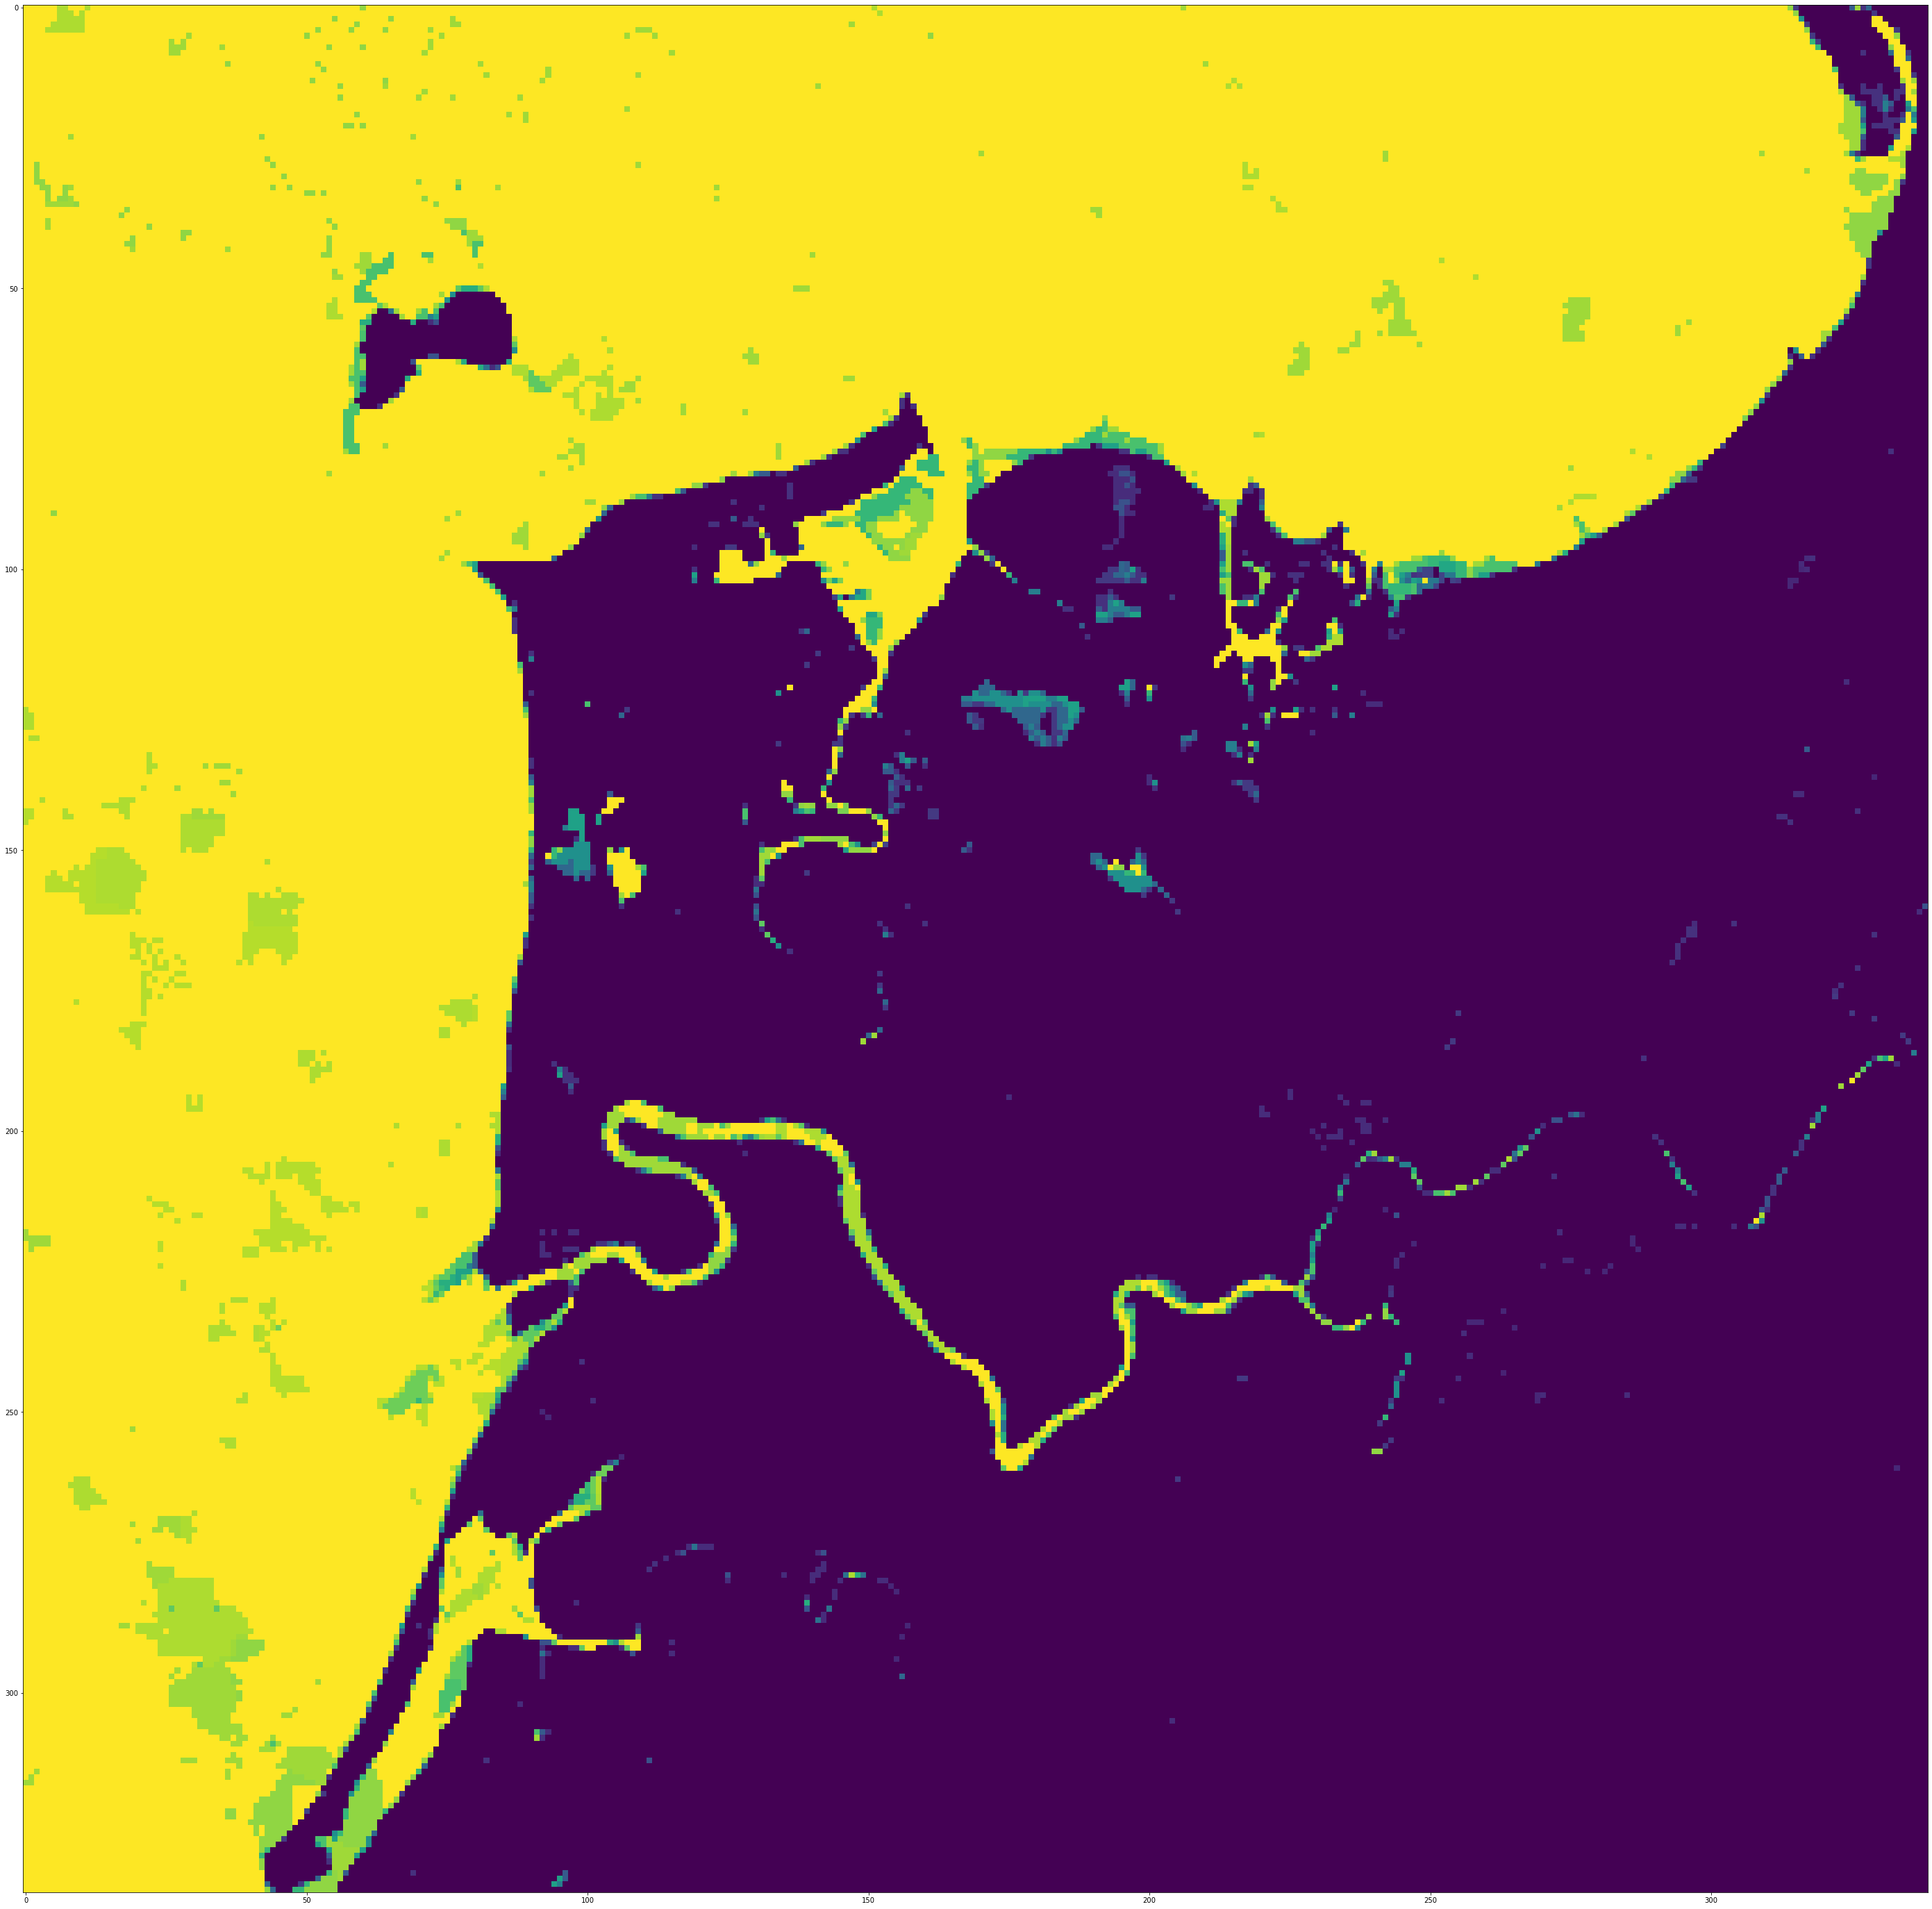

In [42]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_mean)

CPU times: user 37.3 ms, sys: 15.4 ms, total: 52.8 ms
Wall time: 48.6 ms


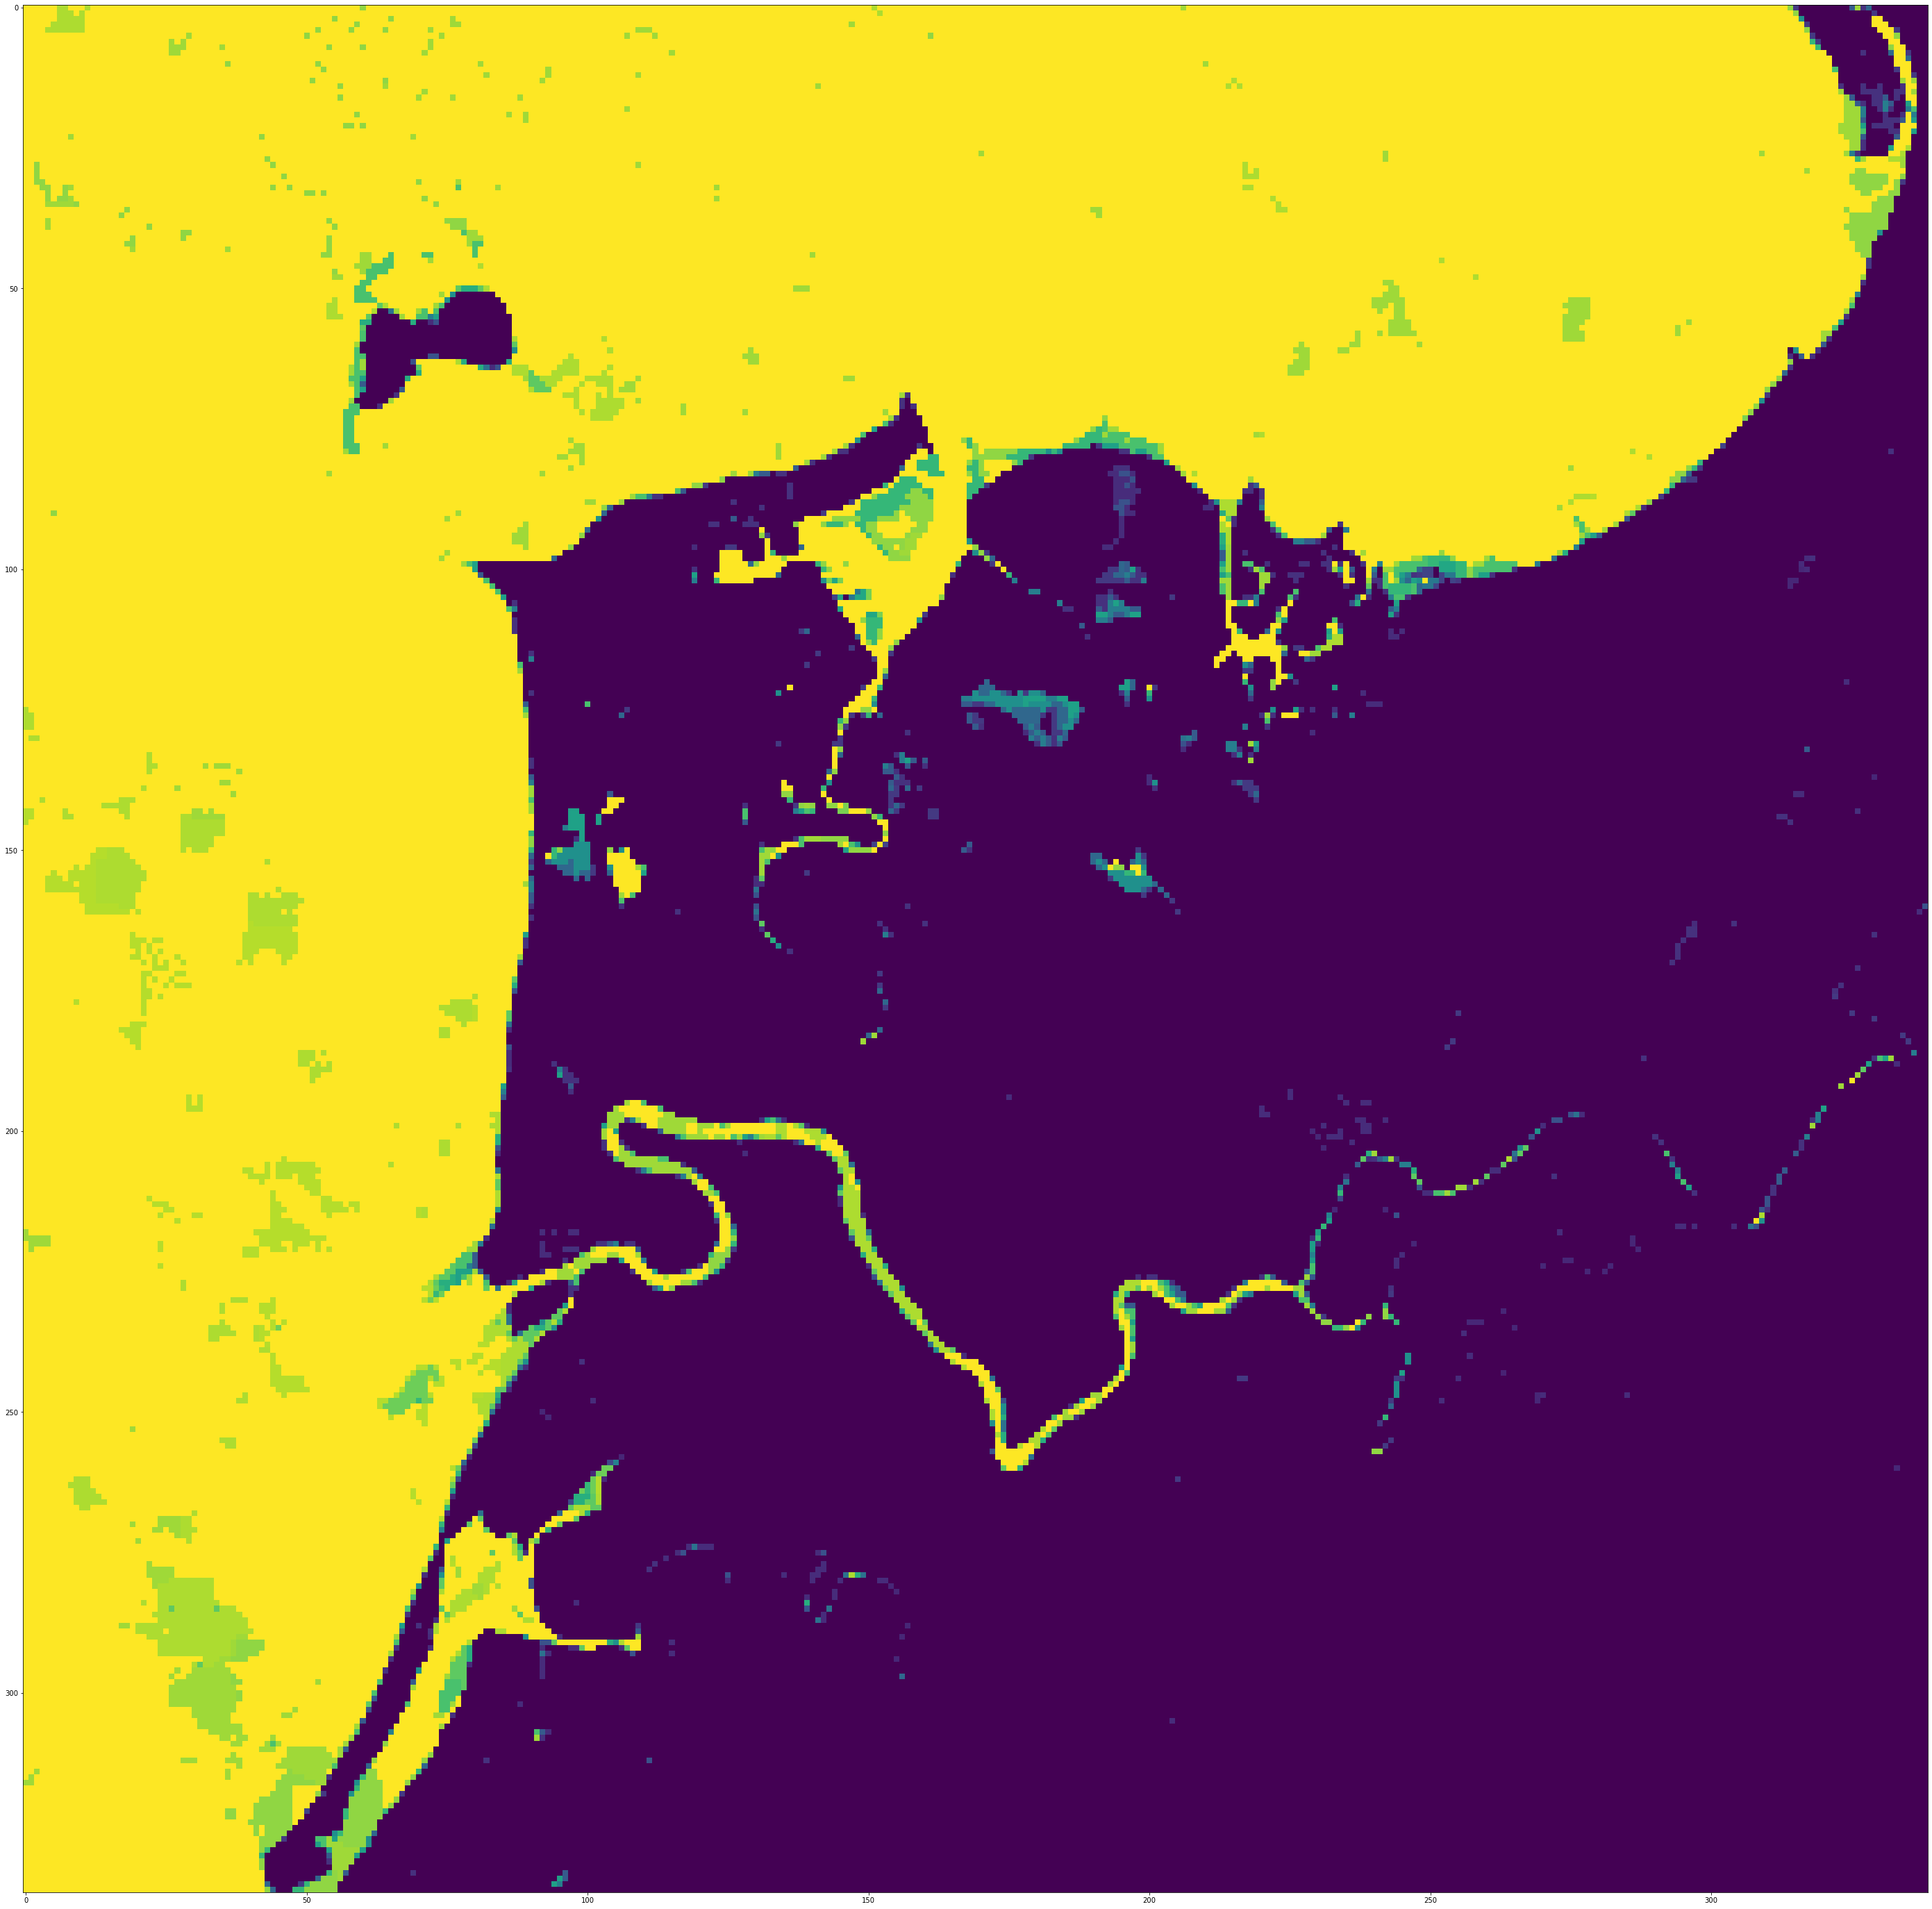

In [43]:
%%time
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_mean)

In [44]:
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client
# del water_dataset
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


In [45]:
%%time
waterpres_prob = 0.3
######THIS BIT SEEMS TO BE NOT DASKABLE?????
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 19.6 ms, sys: 2.88 ms, total: 22.5 ms
Wall time: 22.2 ms


In [46]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterpres_prob) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterpres_prob) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 30 ms, sys: 326 µs, total: 30.3 ms
Wall time: 45.1 ms


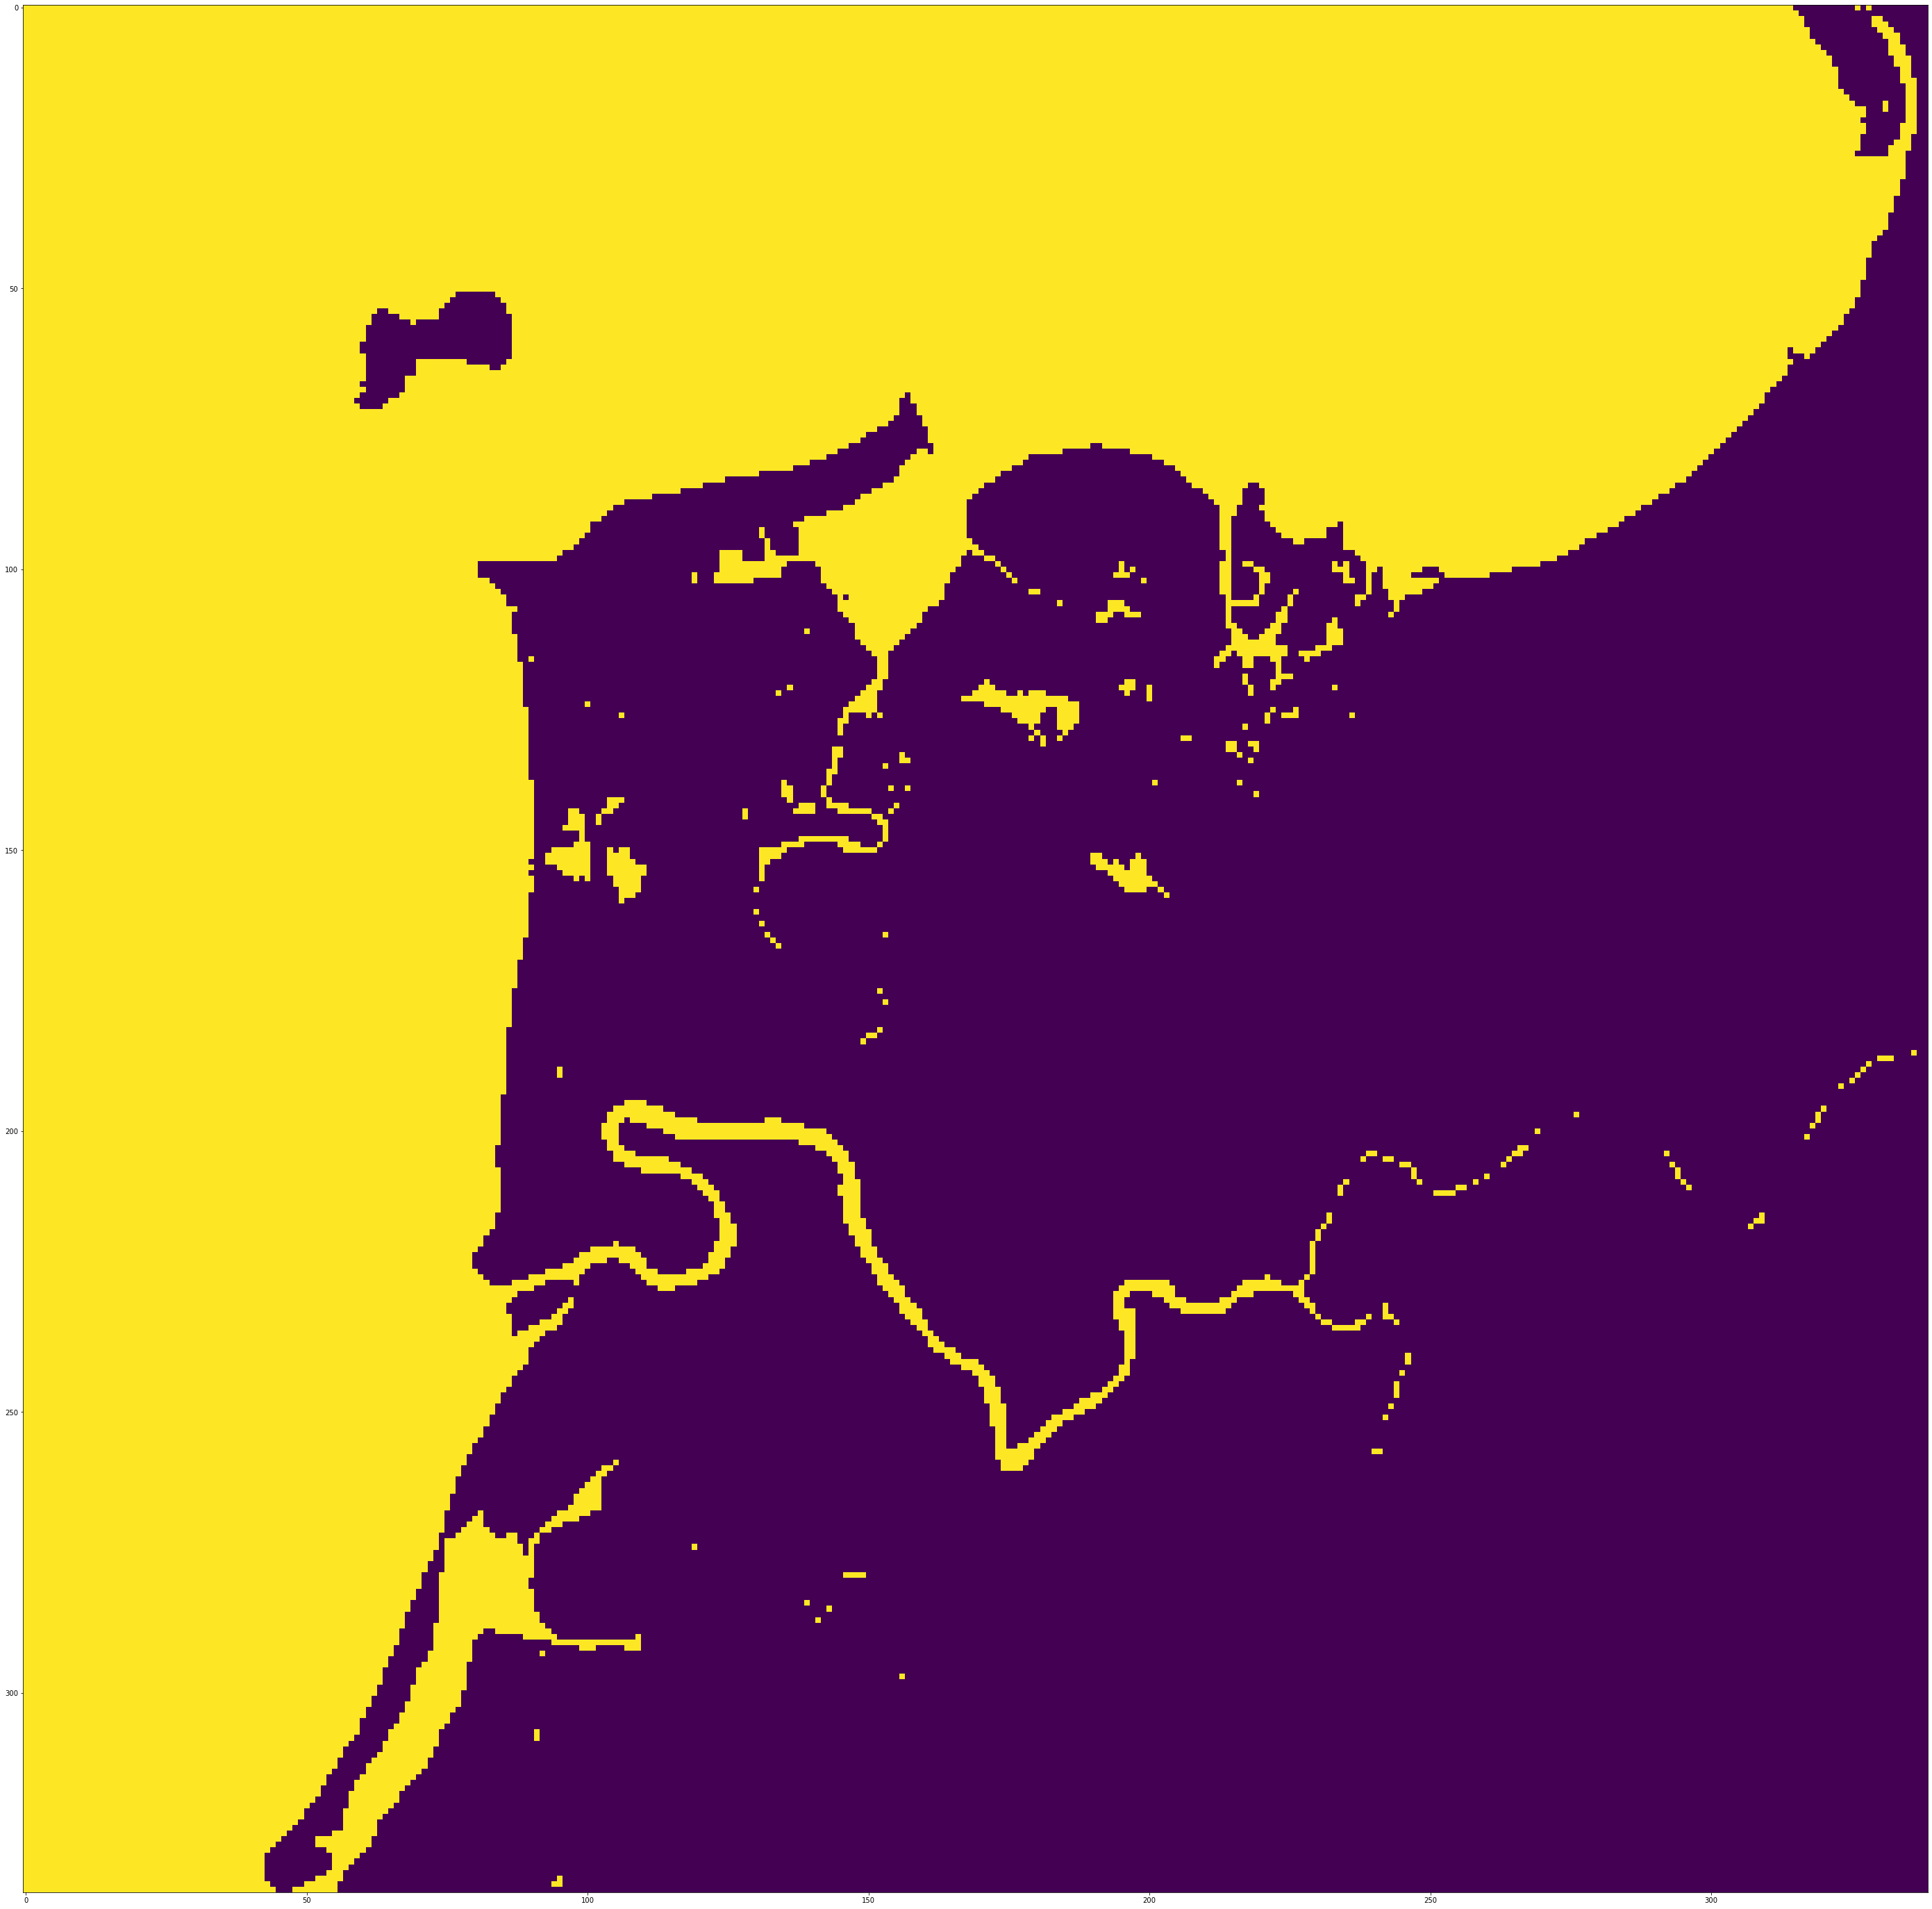

In [47]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc)

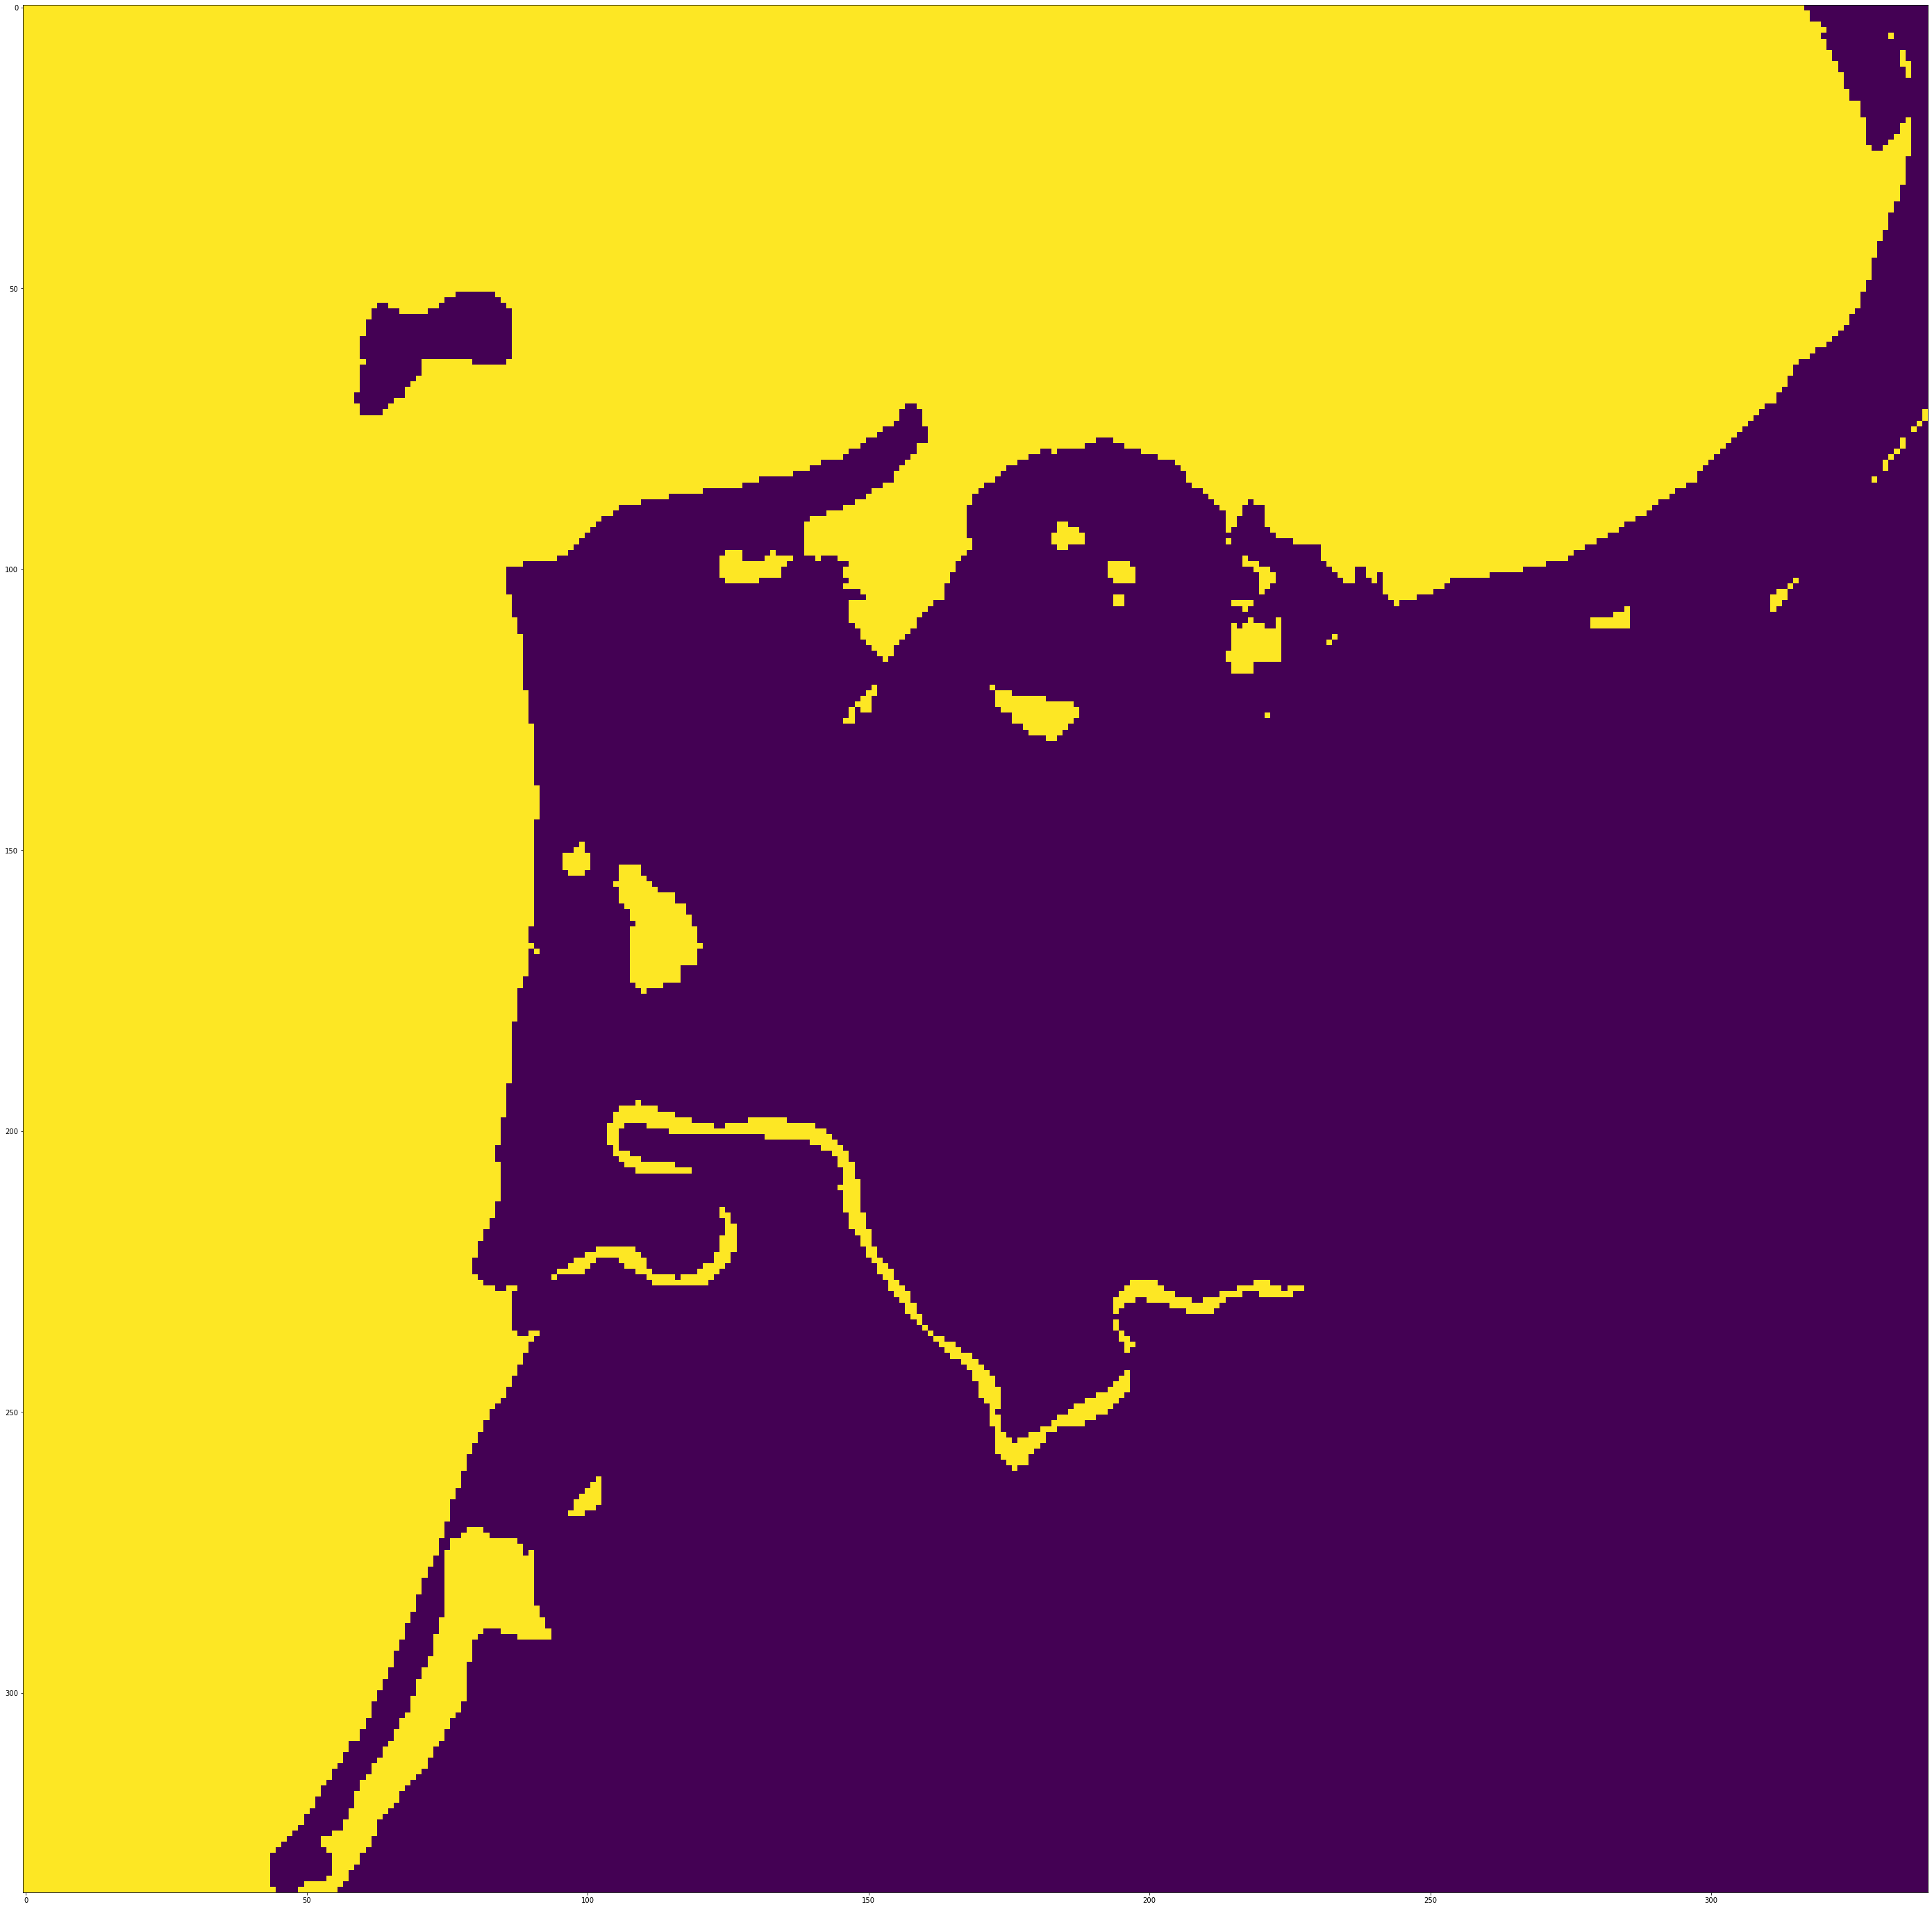

In [48]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc)

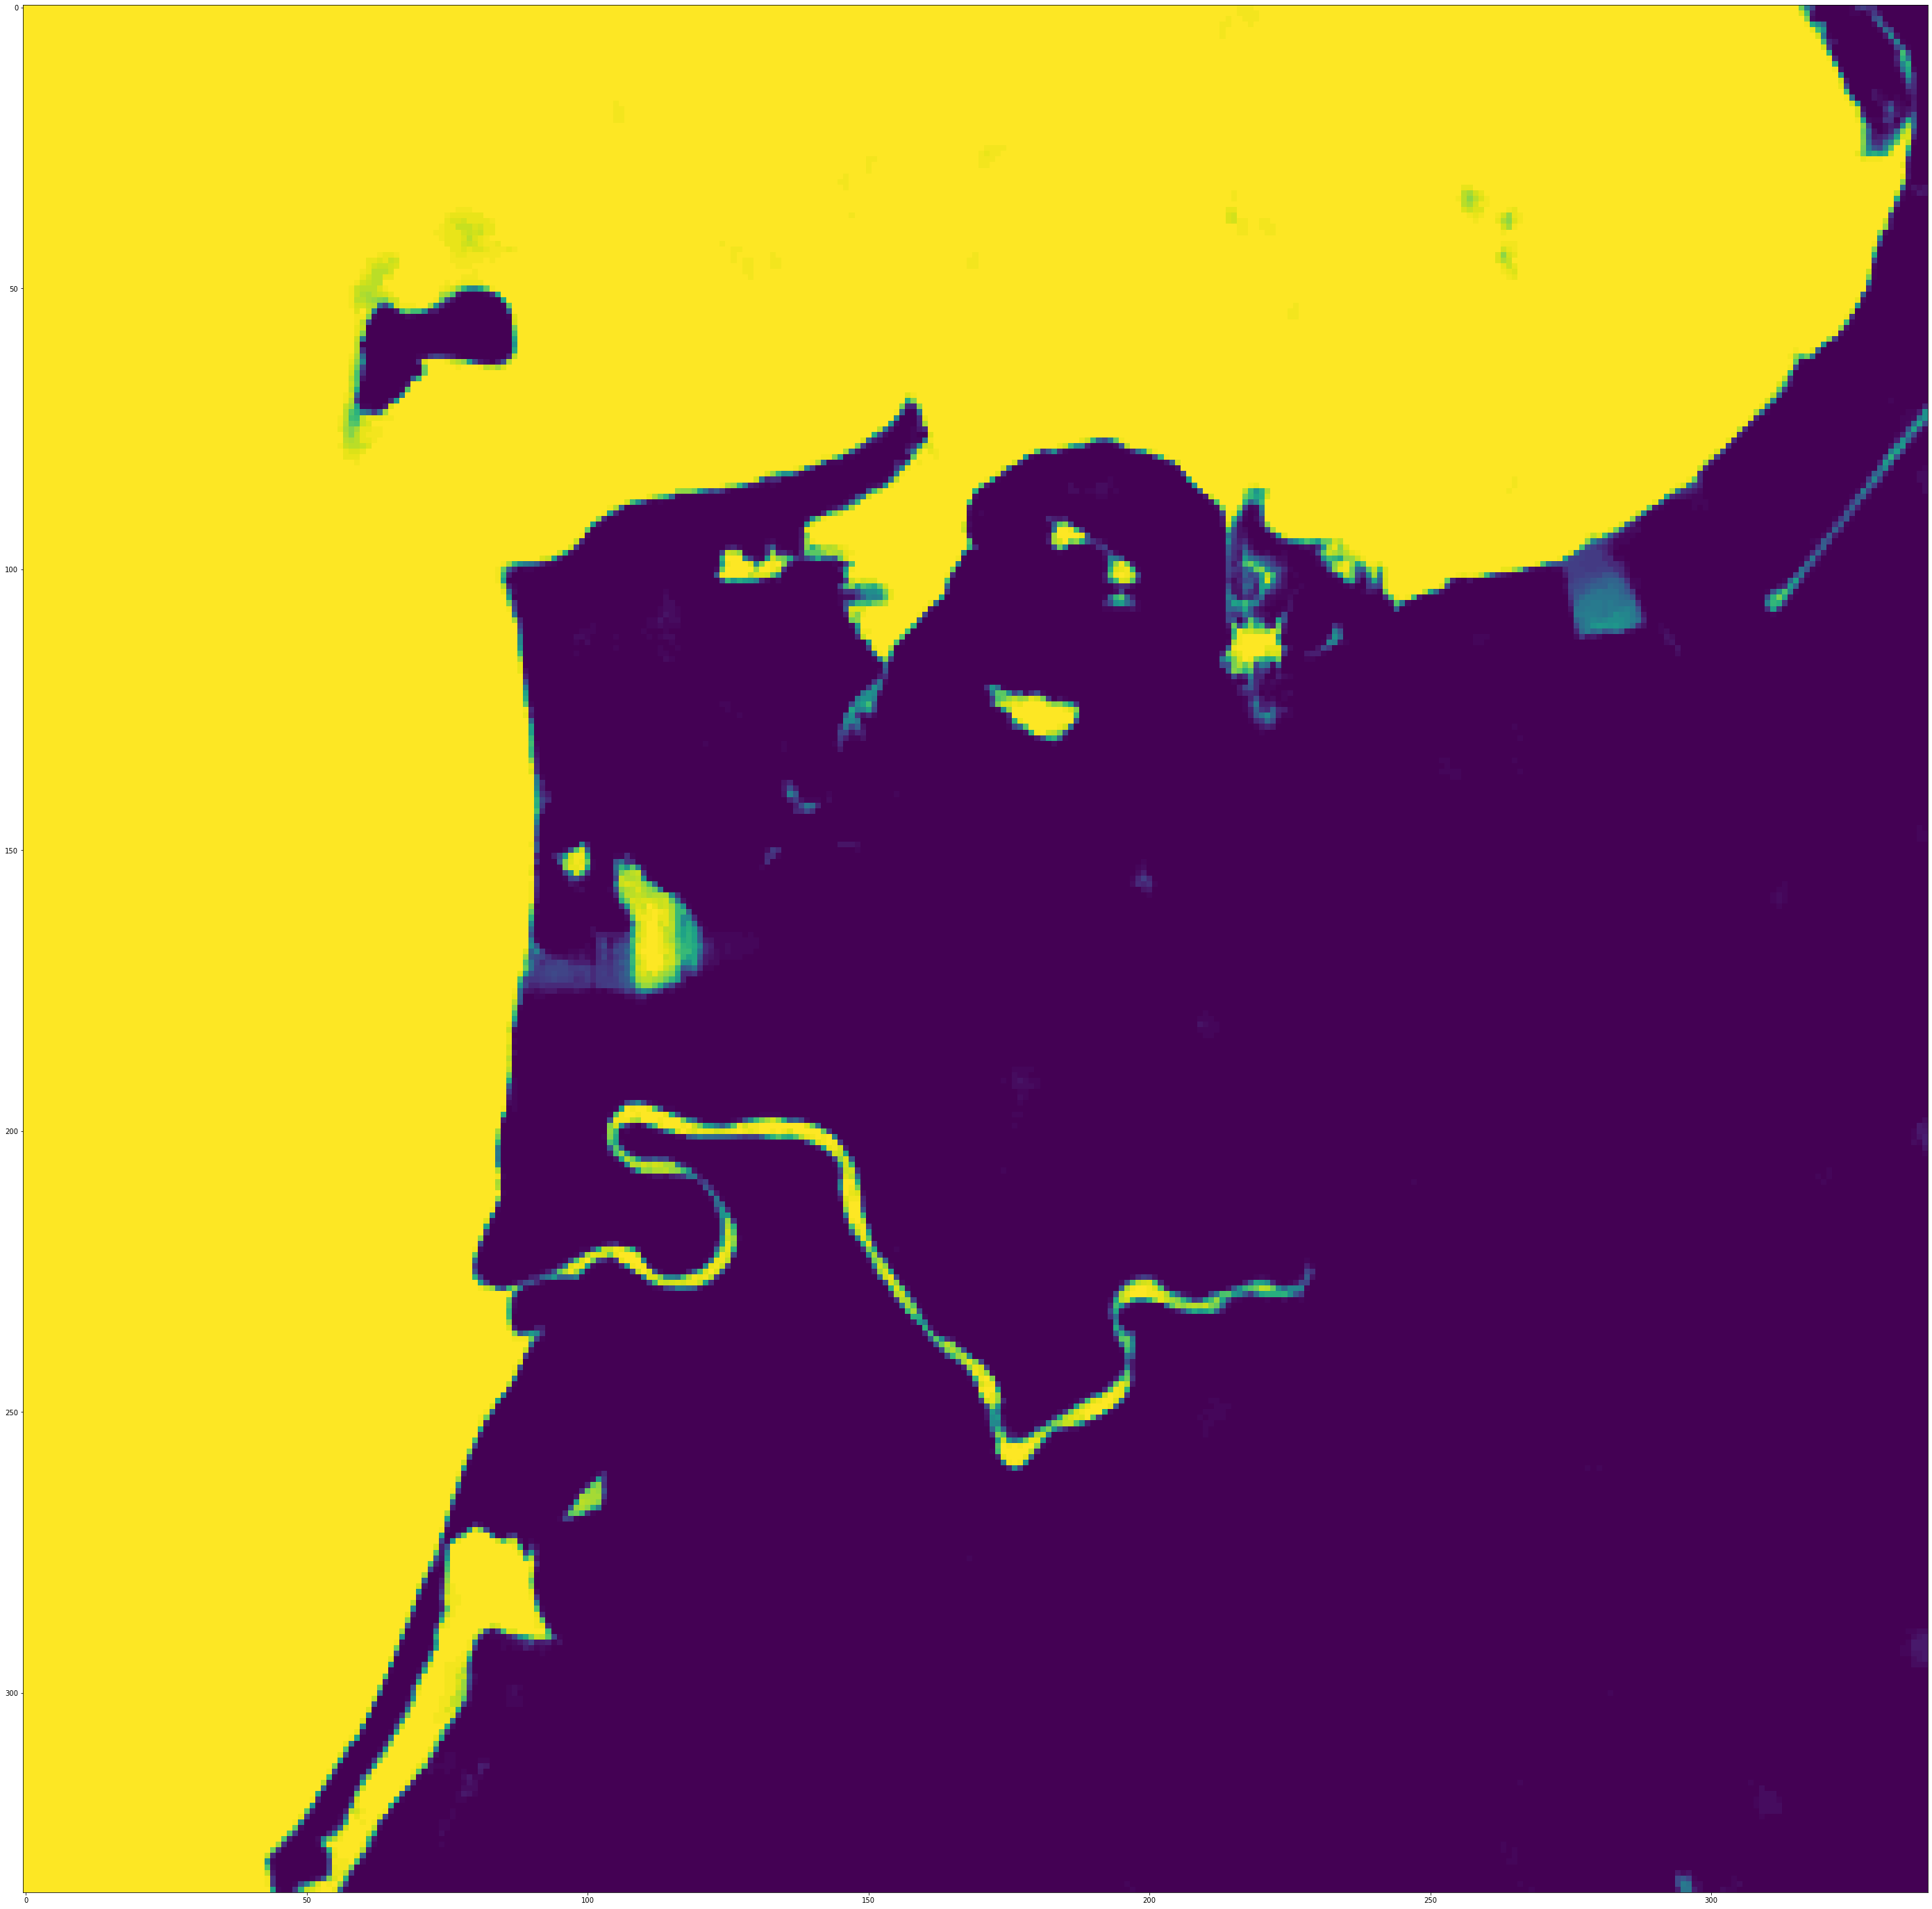

In [49]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_mean)

In [50]:
difference = (wc_analysis_rc - wc_baseline_rc)

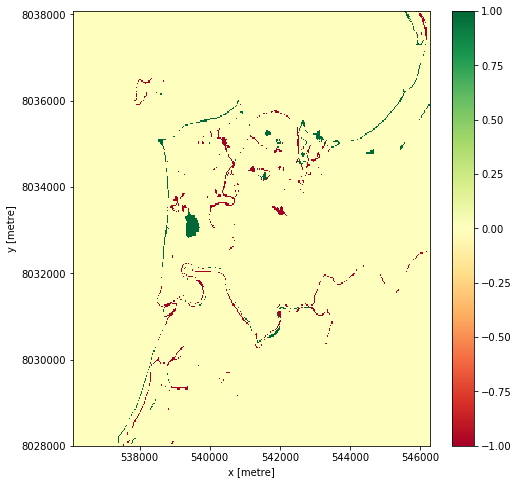

In [51]:
from matplotlib.cm import RdYlGn, Greens
plt.figure(figsize = (8,8))
difference.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [52]:
difference_range = (wc_analysis_mean - wc_baseline_mean)

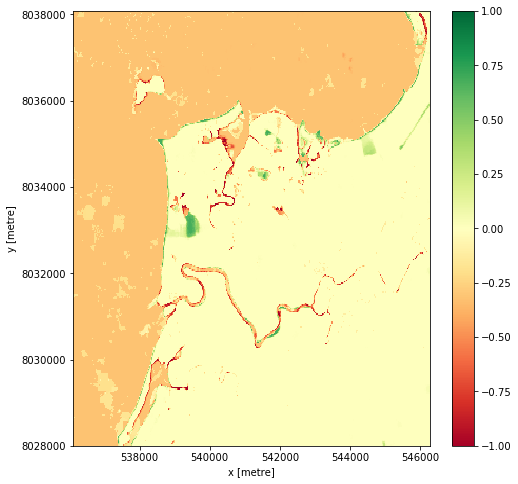

In [53]:
plt.figure(figsize = (8,8))
difference_range.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [54]:
write_geotiff_from_xr('difference_range.tiff', difference_range, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('difference.tiff', difference, crs=output_projection, x_coord = 'x', y_coord = 'y')

---